In [2]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

figsize = (14, 3.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Regression Trees

## Decision Trees for Regression

**Decision Trees can be used for Regression, in which case:**

* Leaves are labeled with the _mean_ of the associated examples:

$$
\text{mean}(y) = \frac{1}{n} \sum_{j = 1}^n y_j
$$

* We split so as to reduce the weighed _variance_:

$$\begin{align}
\frac{|y_{x_j \leq \theta}|}{|y|} \text{Var}(y_{x_j \leq \theta}) +
\frac{|y_{x_j > \theta}|}{|y|} \text{Var}(y_{x_j > \theta}) \\
\text{with: } \text{Var}(y) = \frac{1}{n} \sum_{j = 1}^n (y_j - \text{mean}(y))^2
\end{align}$$

## A Practical Example

**We will apply DT regression to the housing price dataset**

...But first, let's repeat our Linear Regression approach as a baseline:

In [2]:
data = pd.read_csv('data/real_estate.csv', sep=',')
cols = data.columns
X = data[cols[:-1]]
y = np.log(data[cols[-1]])
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.34, random_state=42)
m = LinearRegression()
m.fit(X_tr, y_tr);
lr_pred_tr, lr_pred_ts = m.predict(X_tr), m.predict(X_ts)
print(f'R2: {r2_score(y_tr, lr_pred_tr):.3} (training), {r2_score(y_ts, lr_pred_ts):.3} (test)')

R2: 0.691 (training), 0.645 (test)


We will attempt to improve over these results

## A Practical Example

**We proceed as usual for scikit learn**

First we build a model object:

In [3]:
from sklearn.tree import DecisionTreeRegressor
rtm = DecisionTreeRegressor()

Then we call the `fit` method:

In [4]:
rtm.fit(X_tr, y_tr);

...And finally we evaluate the performance:

In [5]:
rtm_pred_tr, rtm_pred_ts = rtm.predict(X_tr), rtm.predict(X_ts)
print(f'R2: {r2_score(y_tr, rtm_pred_tr):.3} (training), {r2_score(y_ts, rtm_pred_ts):.3} (test)')

R2: 0.994 (training), 0.66 (test)


## Non-Linear Estimators

**The performance gap is very significant**

...At least _on the training set_

* This happens even if DTs are training using a greedy heuristic
* ...While Linear Regression is trained to optimality

**The difference is due to _non-linearity_**

Linear Regression can capture only linear input-output correlations

* We need careful feature engineering to handle non-linearity
* ...And still we cannot easily capture non-linar over multiple attributes


Decisition Trees have no such restriction

* By partitioning the training data
* ...They can learn an any piecewise constant input-output relation

## Overfitting Issues

**That said, our test-set result are not so go: we have _a lot of overfitting_**

This is typical with all simple Decision Tree models

* DTs are very expressive models (often too much!)
* So, we could mitigate the issue by reducing how expressive they are

**Typically, we play with the termination condition**

* Let's try controlling the maximum tree depth
* ...And see what kind of results we get on the training and test set

In [6]:
tmp_r2 = []
for md in range(1, 61):
    tmp_mdl = DecisionTreeRegressor(max_depth=md)
    tmp_mdl.fit(X_tr, y_tr)
    tmp_y_tr, tmp_y_ts = tmp_mdl.predict(X_tr), tmp_mdl.predict(X_ts)
    r2_tr, r2_ts = r2_score(y_tr, tmp_y_tr), r2_score(y_ts, tmp_y_ts)
    tmp_r2.append([r2_tr, r2_ts])

## Bias vs Variance

**Let's plot the R2 values over maximum depth**

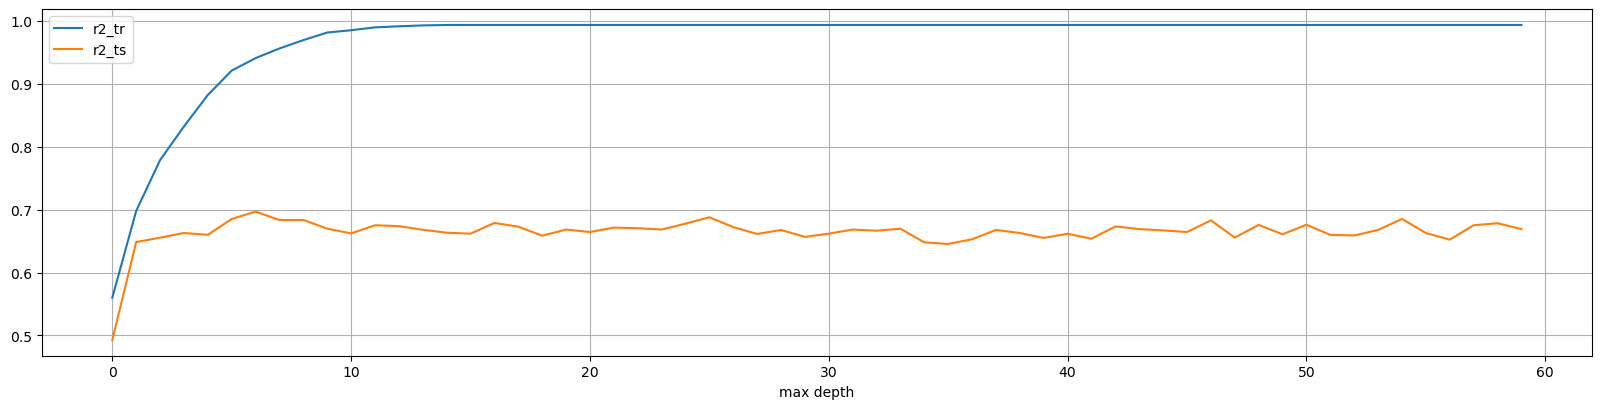

In [7]:
bv = pd.DataFrame(columns=['r2_tr', 'r2_ts'], data=tmp_r2)
ax = bv['r2_tr'].plot(figsize=figsize, legend=True)
bv['r2_ts'].plot(grid=':', legend=True, xlabel='max depth');

* Low-depth trees are less capable of learning the I/O map from the training data
* ...But they have more consistent results on unseen examples

## Bias vs Variance

**Let's plot the R2 values over maximum depth**

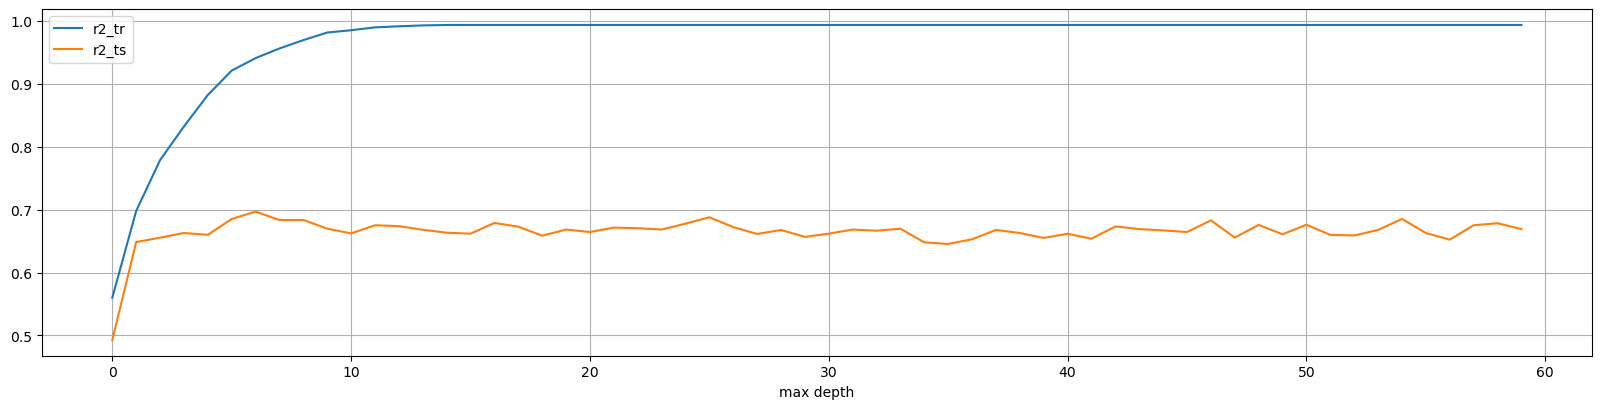

In [8]:
bv = pd.DataFrame(columns=['r2_tr', 'r2_ts'], data=tmp_r2)
ax = bv['r2_tr'].plot(figsize=figsize, legend=True)
bv['r2_ts'].plot(grid=':', legend=True, xlabel='max depth');

* High-depth trees can learn the I/O map from the training data
* ...But they become noisy (or even perform worse!) on unseen examples

## Bias vs Variance

**We call:**

* _Bias_ the tendency of an ML model to behave in a certain, stable way
* _Variance_ the ability to change the output rapidly with input changes

Low-depth leads to higher bias and lower variance (and vice-versa)

**Depth optimization with DTs is usually a good idea**

...Just _don't_ use the test set for that

* Use cross-validation instead!
* For the optimization part, we will use a simple grid search

In [9]:
from sklearn.model_selection import GridSearchCV
rtm_cv = GridSearchCV(rtm, param_grid={'max_depth': np.arange(2, 30)})
rtm_cv.fit(X_tr, y_tr);
print(f'Best results with: {rtm_cv.best_params_}')

Best results with: {'max_depth': 3}


## Results for the Calibrated DT

**Let's check the results for our calibrated DT**

We can obtain them directly from the `GridSearchCV` object

In [10]:
rtm_cv_pred_tr, rtm_cv_pred_ts = rtm_cv.predict(X_tr), rtm_cv.predict(X_ts)
print(f'R2: {r2_score(y_tr, rtm_cv_pred_tr):.3} (training), {r2_score(y_ts, rtm_cv_pred_ts):.3} (test)')

R2: 0.779 (training), 0.656 (test)


We have less overfitting, but the results are also slighly worse

**The reason is in the bias/variance link**

* DTs are very prone to overfitting
* We can increase their bias to reduce that risk
* ...But typically that has also a big impact on variance

**In summary, using _simple_ DTs there is no easy fix for this issue**